# Detectors

Review of all the detectors implemented in ByoTrack
___________________________________________________

1. **Wavelet Detector** (Wavelet decomposition + noise filtering)
2. **StarDist** (Unet + StarConvex prior)

In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

import byotrack

TEST = True  # Set to False to analyze a whole video

## Load a video

In [2]:
video_path = "path/to/video.ext"

# Simply open a video
video = byotrack.Video(video_path)

fps = 20
# fps = video.reader.fps

# Note: video could also be a 4 dimensionnal numpy array

In [3]:
# A transform can be added to normalize and aggregate channels

transform_config = byotrack.VideoTransformConfig(aggregate=True, normalize=True, q_min=0.02, q_max=0.999)
video.set_transform(transform_config)

# Show the min max value used to clip and normalize
print(video._normalizer.mini, video._normalizer.maxi)

[0.] [255.]


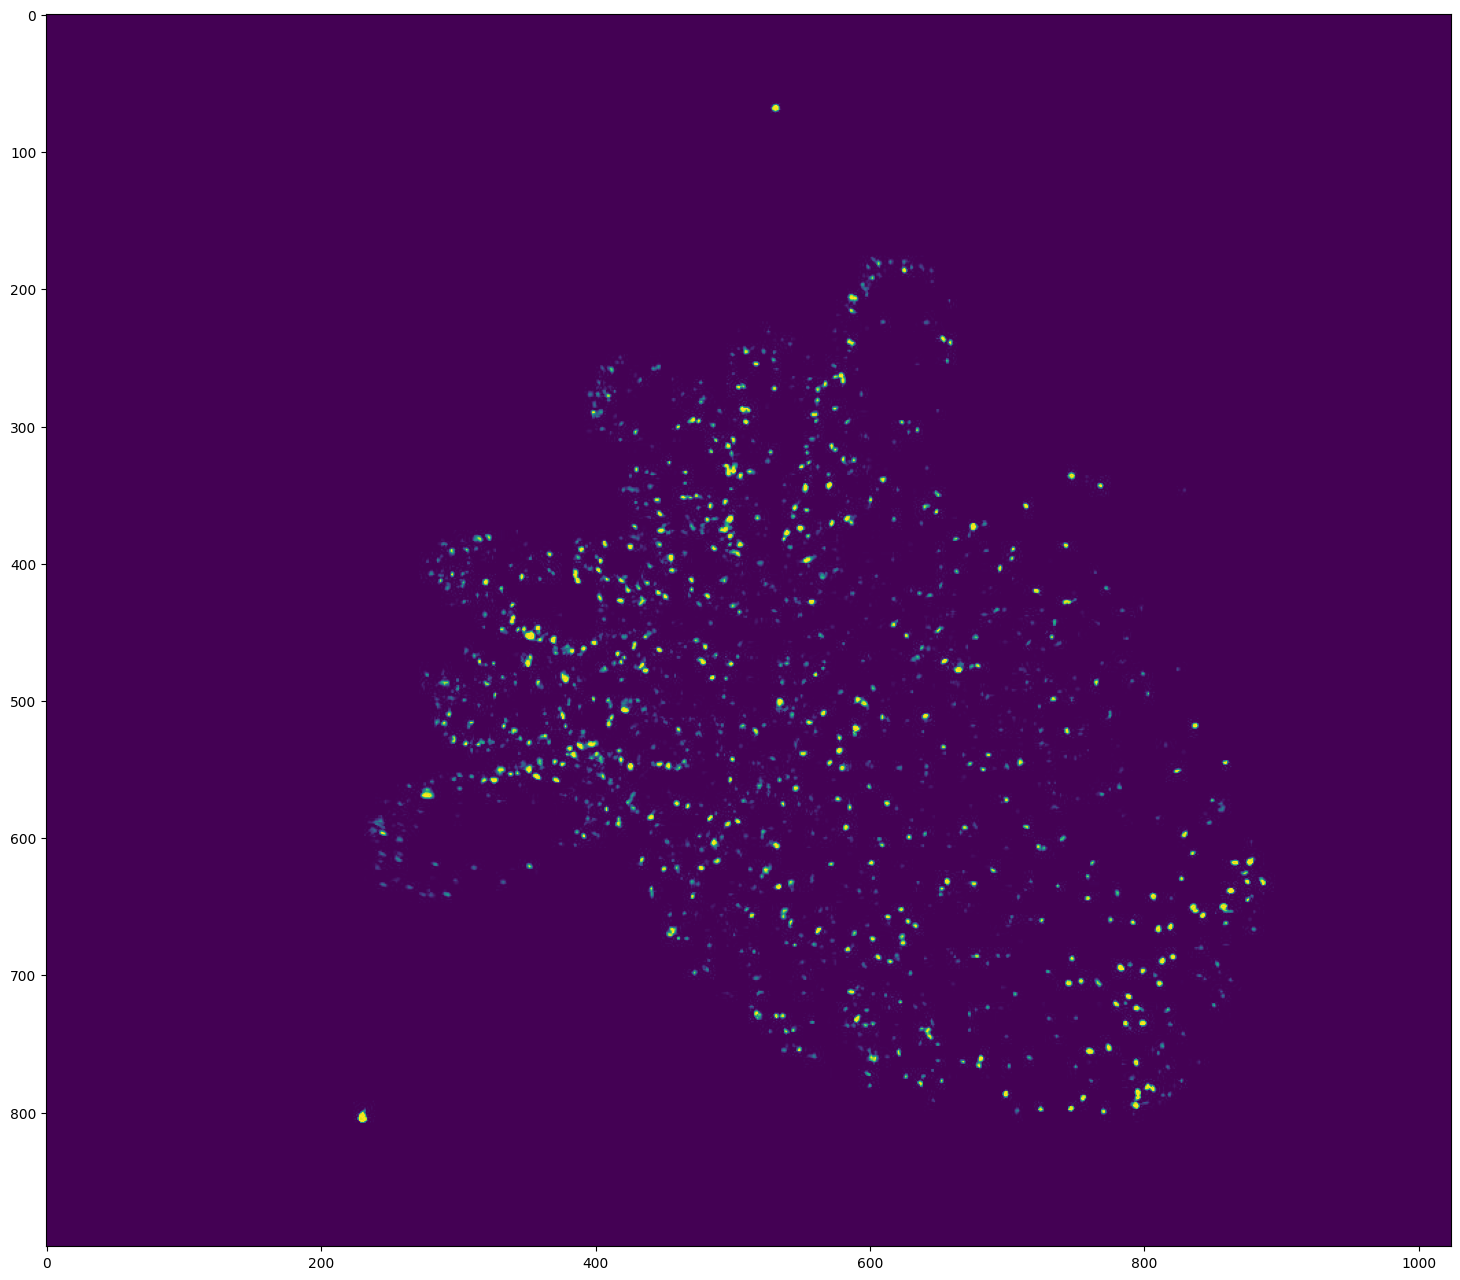

In [4]:
# Display the first frame

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(video[0])
plt.show()

## WaveletDetector

In [5]:
from byotrack.implementation.detector.wavelet import WaveletDetector

WaveletDetector?

In [6]:
# Create the detector object with its hyper parameters. 
# The most important ones being the scale (size of the spots) and k the threshold noise

detector = WaveletDetector(scale=1, k=3.0, min_area=3, batch_size=20, device=torch.device("cpu"))

In [7]:
# Set the hyperparameters manually on the video
# Use w/x to move backward/forward in the video
# Use c/v to update k (noise threshold)
# Use b/n to update the scale (expected size of the spots)
# You can also use the min_area to filter more or less spots given their area

K_SPEED = 0.01
scale = 1

i = 0
detector = WaveletDetector(scale=scale, k=3.0, min_area=3, device=torch.device("cpu"))

while True:
    frame = video[i]

    # Run detection on a single frame using detect
    detections = detector.detect(frame[None, ...])[0]
    mask = (detections.segmentation.numpy() != 0).astype(np.uint8) * 255
    
    image = np.concatenate((frame, np.zeros_like(frame), mask[..., None]), axis=-1)

    # Display the resulting frame
    cv2.imshow('Frame', image)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(video)} - scale={scale}, k={detector.k} - Num detections: {detections.length}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey() & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break
        
    if key == ord("w"):
        i = (i - 1) % len(video)

    if key == ord("x"):
        i = (i + 1) % len(video)
        
    if key == ord("c"):
        detector.k = detector.k * (1 - K_SPEED)

    if key == ord("v"):
        detector.k = detector.k * (1 + K_SPEED)
        
    if key == ord("b"):
        scale = max(0, scale - 1)
        detector = SpotDetector(scale, detector.k, detector.min_area, detector.device)
        
    
    if key == ord("n"):
        scale = min(4, scale + 1)
        detector = SpotDetector(scale, detector.k, detector.min_area, detector.device)


cv2.destroyAllWindows()

In [8]:
# Run the detection process on the current video

if TEST:  # Use slicing on video to run detection only on a part of it
    detections_sequence = detector.run(video[:50])
else:
    detections_sequence = detector.run(video)

Detections (Wavelet): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.85it/s]


## StarDist 

In [9]:
from byotrack.implementation.detector.stardist import StarDistDetector

StarDistDetector?

2023-06-26 15:19:14.147355: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-26 15:19:14.173294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 15:19:14.565912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
# Create the detector object from a trained model. Note that the training should be done with
# the official implementation (https://github.com/stardist/stardist).
# Hyperparameters are set during the training phase (nms_treshold and prob_threshold)
# They can be changed manually (See next cells)

model_path = "path/to/trained/model/"
detector = StarDistDetector(model_path, batch_size=5)

stardist.py (41): Current implementation do not support batch size greater than 1 and will iterate image by image
2023-06-26 15:19:22.625216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-06-26 15:19:22.625241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: rreme-pasteur
2023-06-26 15:19:22.625244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: rreme-pasteur
2023-06-26 15:19:22.625296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 510.108.3
2023-06-26 15:19:22.625308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 510.108.3
2023-06-26 15:19:22.625310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 510.108.3


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.710898, nms_thresh=0.3.


In [11]:
# Set the hyperparameters manually on the video
# Use w/x to move backward/forward in the video
# Use c/v to update prob_threshold (The most probable spots are kept)
# Use b/n to update the nms_threshold (Delete overlapping spots)
# You can also the min_area to filter more or less spots given their area

prob_speed = 0.1
nms_speed = 0.2

i = 0
detector = StarDistDetector(model_path, batch_size=5)

while True:
    frame = video[i]

    # Run detection on a single frame using detect
    detections = detector.detect(frame[None, ...])[0]
    mask = (detections.segmentation.numpy() != 0).astype(np.uint8) * 255

    image = np.concatenate((frame, np.zeros_like(frame), mask[..., None]), axis=-1)

    # Display the resulting frame
    cv2.imshow('Frame', image)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(video)} - prob={detector.prob_threshold}, nms={detector.nms_threshold} - Num detections: {detections.length}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey() & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break
        
    if key == ord("w"):
        i = (i - 1) % len(video)

    if key == ord("x"):
        i = (i + 1) % len(video)
        
    if key == ord("c"):
        detector.prob_threshold = detector.prob_threshold * (1 - prob_speed)

    if key == ord("v"):
        detector.prob_threshold = detector.prob_threshold * (1 + prob_speed)

    if key == ord("b"):
        detector.nms_threshold = detector.nms_threshold * (1 - nms_speed)

    if key == ord("n"):
        detector.nms_threshold = detector.nms_threshold * (1 + nms_speed)


cv2.destroyAllWindows()

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.710898, nms_thresh=0.3.


In [12]:
# Run the detection process on the current video

if TEST:  # Use slicing on video to run detection only on a part of it
    detections_sequence = detector.run(video[:20])
else:
    detections_sequence = detector.run(video)

Detections (StarDist): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.80it/s]


## Visualize the detections

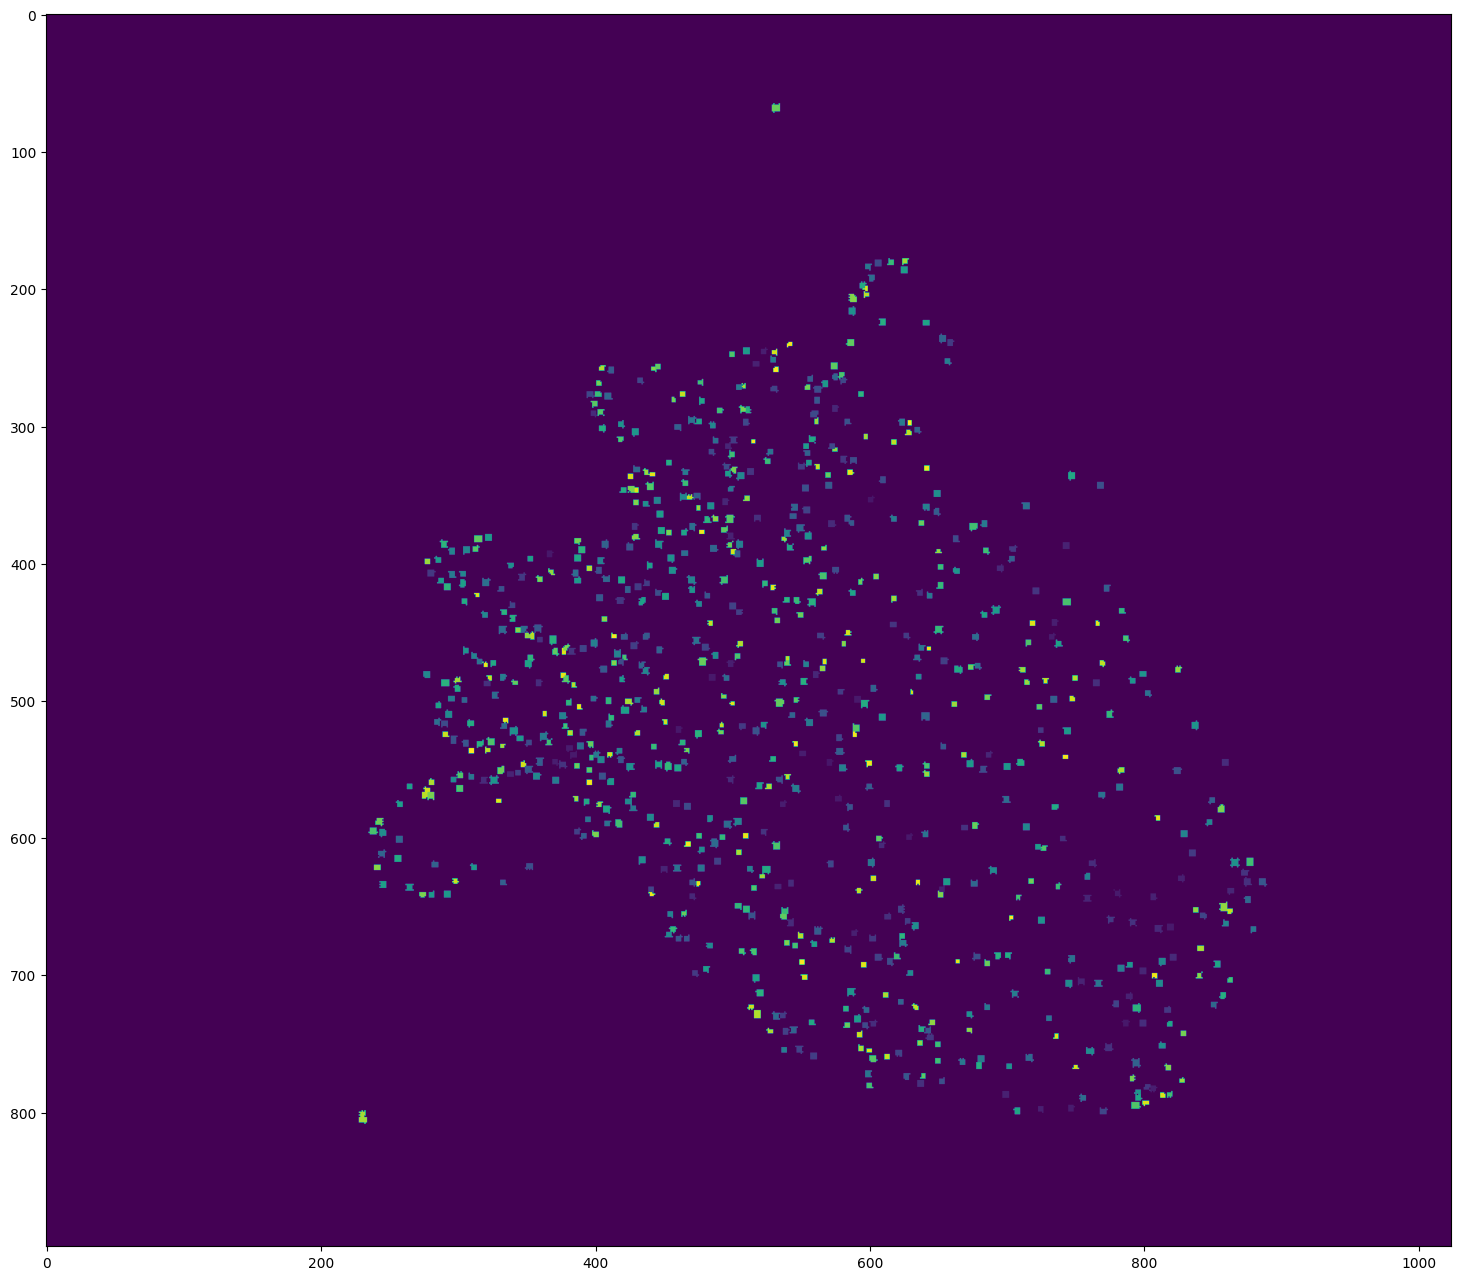

In [13]:
# Display the first detections

segmentation = detections_sequence[0].segmentation.clone()
segmentation[segmentation!=0] += 50  # Improve visibility of firsts labels

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(segmentation)
plt.show()

In [14]:
# Display the detections with opencv
# Use w and x to move backward/forward in the video
# Use c to switch display mode (None / mask / segmentation)

display = 1
i = 0
while True:
    mask = (detections_sequence[i].segmentation.numpy() != 0).astype(np.uint8) * 255
    segmentation = detections_sequence[i].segmentation.clone().numpy()
    segmentation = (segmentation % 206) + 50
    segmentation[detections_sequence[i].segmentation == 0] = 0
    segementation = segmentation.astype(np.uint8)
    frame = (video[i] * 255).round().astype(np.uint8)
    if display == 0:
        image = np.concatenate((np.zeros_like(frame), frame, np.zeros_like(frame)), axis=-1)
    elif display == 1:
        image = np.concatenate((np.zeros_like(frame), frame, mask[..., None]), axis=-1)
    else:
        image = np.concatenate((np.zeros_like(frame), frame, segementation[..., None]), axis=-1)
    
    # Display the resulting frame
    cv2.imshow('Frame', image)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(detections_sequence)} - Number of detections: {detections_sequence[i].length}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey() & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break
        
    if key == ord("w"):
        i = (i - 1) % len(detections_sequence)

    if key == ord("x"):
        i = (i + 1) % len(detections_sequence)
        
    if key == ord("c"):
        display = (display + 1) % 3

cv2.destroyAllWindows()